In [41]:
import pandas as pd
import yfinance as yf
import datetime
from fredapi import Fred
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from hyperopt import hp
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, Trials
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [42]:
# Set your FRED API key in the environment (this line is correct)
os.environ['FRED_API_KEY'] = '7cd90f6c84b53379f448cd4a6552c7ef'

# Initialize the Fred object
fred = Fred()

# Define start and end dates
start_date = datetime.datetime(2014, 1, 1) 
end_date = datetime.datetime(2019, 12, 31)

# Download SPTL data using yfinance
sptl_data = yf.download('SPTL', start=start_date, end=end_date)

# Fetch the EFFR data
effr_data = fred.get_series('EFFR', observation_start=start_date, observation_end=end_date)

# Convert EFFR data to a DataFrame and adjust for daily
effr_data_df = pd.DataFrame(effr_data, columns=['EFFR'])
dc = 1/252
effr_data_df['EFFR_Adjusted'] = effr_data_df['EFFR'] * dc

# Removing NAN values
effr_data_df = effr_data_df.dropna(inplace=False)
sptl_data = sptl_data.dropna(inplace=False)

# Check the first few rows of each DataFrame
print(effr_data_df.tail())
sptl_data.head()

[*********************100%%**********************]  1 of 1 completed


            EFFR  EFFR_Adjusted
2019-12-24  1.55       0.006151
2019-12-26  1.55       0.006151
2019-12-27  1.55       0.006151
2019-12-30  1.55       0.006151
2019-12-31  1.55       0.006151


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.299051,25400
2014-01-03,29.959999,30.105000,29.959999,30.035,23.283546,22000
2014-01-06,30.110001,30.270000,30.110001,30.160,23.380444,3200
2014-01-07,30.240000,30.260000,30.200001,30.260,23.457968,3800
2014-01-08,30.075001,30.184999,30.075001,30.150,23.372694,14800


In [43]:
# Calculating the return per unit of SPTL
sptl_data['Return'] = sptl_data['Close'].pct_change()

# Calculatin Excess Return
sptl_data['Excess_Return'] = sptl_data['Return'] - effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')

sptl_data.head()

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_20671/2675490396.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['Excess_Return'] = sptl_data['Return'] - effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


,Open,High,Low,Close,Adj Close,Volume,Return,Excess_Return
Date,,,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.299051,25400,NaN,NaN
2014-01-03,29.959999,30.105000,29.959999,30.035,23.283546,22000,-0.000665,-0.000983
2014-01-06,30.110001,30.270000,30.110001,30.160,23.380444,3200,0.004162,0.003844
2014-01-07,30.240000,30.260000,30.200001,30.260,23.457968,3800,0.003316,0.003038
2014-01-08,30.075001,30.184999,30.075001,30.150,23.372694,14800,-0.003635,-0.003913


In [44]:
# Define the range of moving averages and Z-score thresholds to test
moving_average_periods = [20, 50, 100, 150, 200]
z_score_thresholds = [0.5, 1, 1.5, 2.5, 3]

# Initialize a DataFrame to store the results of the grid search
grid_search_results = pd.DataFrame(columns=['MA_Period', 'Z_Score_Threshold', 'Metric'])

# Initialize a list to store the results of the grid search
grid_search_results_list = []

# Define initial capital, leverage, and maximum dollar value
V0 = 200000.00  # Initial capital
L = 10  # Leverage
max_dollar_value = V0 * L  # Maximum dollar value of SPTL that can be held

# Calculate the number of rows in the data that corresponds to the training set
train_size = 0.7  # 70% of the data for training
train_rows = int(len(sptl_data) * train_size)

# Calculate the average EFFR adjusted rate for the training set to use in the PnL calculation
effr_adjusted_avg = effr_data_df['EFFR_Adjusted'].iloc[:train_rows].mean()

# Define a function to calculate the PnL based on the provided formula
def calculate_pnl(data, holding_period='1D'):
    # Calculate the PnL
    data['PnL'] = (data['Close'].pct_change() - data['EFFR_Adjusted']) * data['Position']
    return data['PnL'].resample(holding_period).sum()

# Define a metric for evaluation, e.g., total return or Sharpe ratio
def evaluate_strategy(returns, risk_free_rate=effr_adjusted_avg):
    # Simple total return calculation; replace with desired metric
    #total_return = returns.sum()
    #return total_return
    daily_risk_free_rate = np.power(1 + risk_free_rate, 1/252) - 1
    
    # Calculate the average daily return and daily standard deviation of returns
    avg_daily_return = returns.mean()
    std_dev = returns.std()
    
    # Calculate the Sharpe Ratio, adjusted for daily returns
    sharpe_ratio = (avg_daily_return - daily_risk_free_rate) / std_dev
    
    return sharpe_ratio


# Loop through each combination of moving average period and Z-score threshold
for ma_period in moving_average_periods:
    for z_threshold in z_score_thresholds:
        # Calculate moving average and standard deviation
        sptl_data['Moving_Average'] = sptl_data['Close'].rolling(window=ma_period).mean()
        sptl_data['MA_Std'] = sptl_data['Close'].rolling(window=ma_period).std()

        # Calculate Z-score
        sptl_data['Z_Score'] = (sptl_data['Close'] - sptl_data['Moving_Average']) / sptl_data['MA_Std']

        # Generate signals based on Z-score
        sptl_data['Signal'] = 0
        sptl_data.loc[sptl_data['Z_Score'] < -z_threshold, 'Signal'] = 1  # Buy signal
        sptl_data.loc[sptl_data['Z_Score'] > z_threshold, 'Signal'] = -1  # Sell signal

        # Calculate the position (dollar value of SPTL held)
        sptl_data['Position'] = sptl_data['Signal'].shift(1) * max_dollar_value

        # Reindex EFFR_Adjusted to align with sptl_data
        sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')

        # Calculate daily returns and apply the PnL formula
        sptl_data['PnL'] = calculate_pnl(sptl_data)

        # Evaluate the strategy on the training set
        sptl_train_data = sptl_data.iloc[:train_rows].copy()
        metric_value = evaluate_strategy(sptl_train_data['PnL'])

        # Append to the results list
        grid_search_results_list.append({
            'MA_Period': ma_period,
            'Z_Score_Threshold': z_threshold,
            'Metric': metric_value
        })

# Convert the list of results into a DataFrame after the loop
grid_search_results = pd.DataFrame(grid_search_results_list)

# Identify the best parameters
best_parameters = grid_search_results.loc[grid_search_results['Metric'].idxmax()]

print(f'Best Parameters:\n{best_parameters}')

Best Parameters:
MA_Period            20.000000
Z_Score_Threshold     1.500000
Metric                0.047799
Name: 2, dtype: float64


/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_20671/3903265618.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_20671/3903265618.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


In [45]:
# Initial capital
V0 = 200000.00

# Leverage
L = 10

# Maximum dollar value of SPTL that can be held, given the leverage
max_dollar_value = V0 * L
# Use the best parameters from the grid search output
best_ma_period = best_parameters['MA_Period']
best_z_threshold = best_parameters['Z_Score_Threshold']
# Position storage
positions = [0]
dVt = []
max_value = [0]

# Calculate moving average and standard deviation for the entire dataset
sptl_data['Moving_Average'] = sptl_data['Close'].rolling(window=int(best_ma_period)).mean()
sptl_data['MA_Std'] = sptl_data['Close'].rolling(window=int(best_ma_period)).std()

# Calculate Z-score for the entire dataset
sptl_data['Z_Score'] = (sptl_data['Close'] - sptl_data['Moving_Average']) / sptl_data['MA_Std']

# Generate signals based on the best Z-score threshold
sptl_data['Signal'] = 0
sptl_data.loc[sptl_data['Z_Score'] < -best_z_threshold, 'Signal'] = 1  # Buy signal
sptl_data.loc[sptl_data['Z_Score'] > best_z_threshold, 'Signal'] = -1  # Sell signal

# Reindex the EFFR data to align with sptl_data
sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


# Separate the training and test data
sptl_test_data = sptl_data.iloc[train_rows:].copy()

# Initialize a list to store the evolution of V0 over time
Vt_evolution = [V0]

# Calculate the daily returns for SPTL
sptl_test_data['Pct_Change'] = sptl_test_data['Close'].pct_change()
pnl = 0

# Simulate the trading strategy on the test data
for index, row in sptl_test_data.iterrows():
    # Calculate the position based on the signal
    # Handle the first iteration where there is no previous signal
    if index == sptl_test_data.index[0]:
        position = 0  # No position on the first day
    else:
        previous_signal = sptl_test_data.loc[sptl_test_data.index < index, 'Signal'].iloc[-1]
        max_value.append(max_dollar_value / L)
        position = previous_signal * (round((max_dollar_value / row['Close']), 0) * row['Close'])
        positions.append(position)  # Store the position for the row
    
    
    # Calculate PnL for the row
    if not np.isnan(row['MA_Std']) and not np.isnan(row['Pct_Change']):  # Avoid calculations before sufficient data for MA/STD
        pnl = (row['Pct_Change'] - row['EFFR_Adjusted']) * position
        V0 += pnl  # Update V0 with the PnL
        Vt_evolution.append(V0)  # Append the new V0 to the evolution list
    # Update the maximum dollar value based on the new V0
    max_dollar_value = min(200000 * L, V0 * L)

    dVt.append(pnl) # Store the PnL for the row
sptl_test_data['Position'] = positions  # Store the positions in the DataFrame
sptl_test_data['Vt'] = max_value
sptl_test_data['dVt'] = dVt
# Print the evolution of V0 over time
for i, value in enumerate(Vt_evolution):
    print(f"Day {i}: V0 = {value:.2f}")

print(positions)


Day 0: V0 = 200000.00
Day 1: V0 = 210771.82
Day 2: V0 = 229049.24
Day 3: V0 = 229049.24
Day 4: V0 = 229049.24
Day 5: V0 = 229049.24
Day 6: V0 = 229049.24
Day 7: V0 = 244114.66
Day 8: V0 = 244114.66
Day 9: V0 = 244114.66
Day 10: V0 = 253429.62
Day 11: V0 = 255877.89
Day 12: V0 = 270350.75
Day 13: V0 = 298586.71
Day 14: V0 = 298586.71
Day 15: V0 = 298586.71
Day 16: V0 = 298586.71
Day 17: V0 = 298586.71
Day 18: V0 = 298586.71
Day 19: V0 = 298586.71
Day 20: V0 = 298586.71
Day 21: V0 = 298586.71
Day 22: V0 = 298586.71
Day 23: V0 = 298586.71
Day 24: V0 = 298586.71
Day 25: V0 = 298586.71
Day 26: V0 = 270546.91
Day 27: V0 = 258227.27
Day 28: V0 = 235362.10
Day 29: V0 = 208332.81
Day 30: V0 = 207877.86
Day 31: V0 = 209693.31
Day 32: V0 = 209693.31
Day 33: V0 = 209693.31
Day 34: V0 = 209693.31
Day 35: V0 = 209693.31
Day 36: V0 = 209693.31
Day 37: V0 = 209693.31
Day 38: V0 = 209693.31
Day 39: V0 = 209693.31
Day 40: V0 = 209693.31
Day 41: V0 = 209693.31
Day 42: V0 = 209693.31
Day 43: V0 = 209693.3

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_20671/4250253114.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


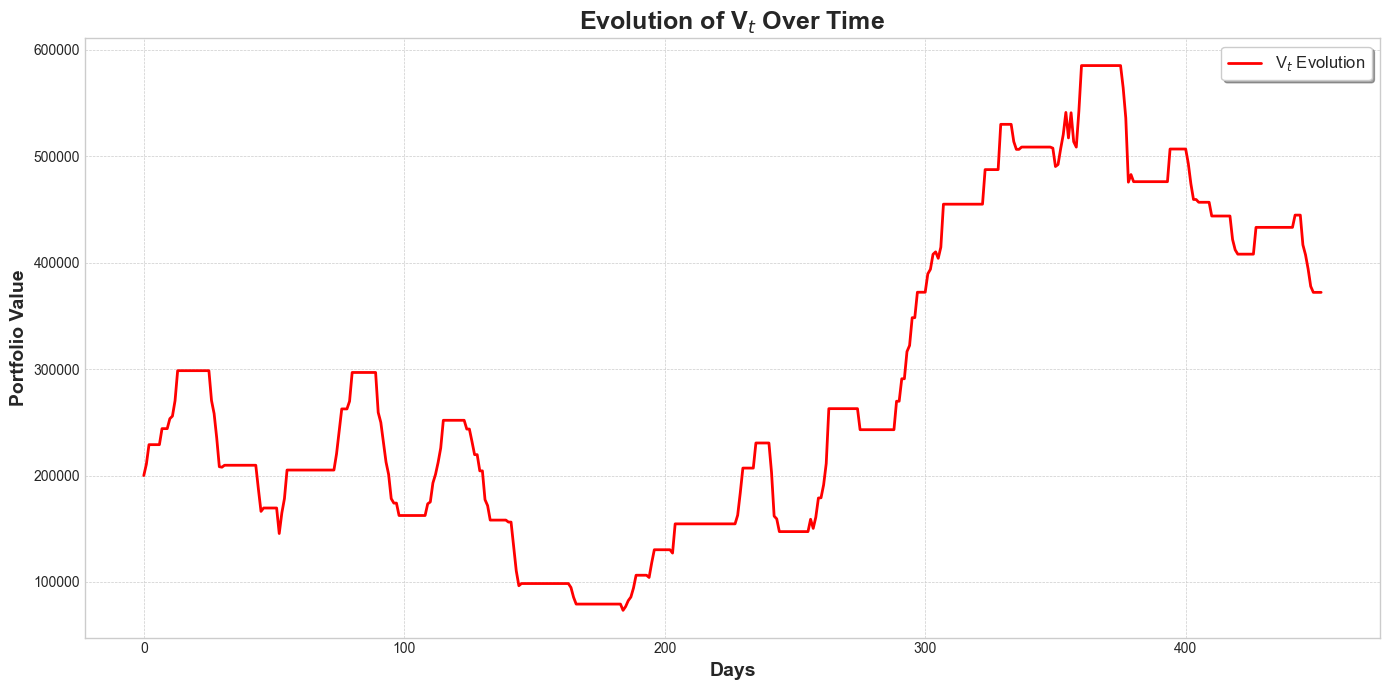

In [46]:
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(Vt_evolution, label='V$_t$ Evolution', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Evolution of V$_t$ Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

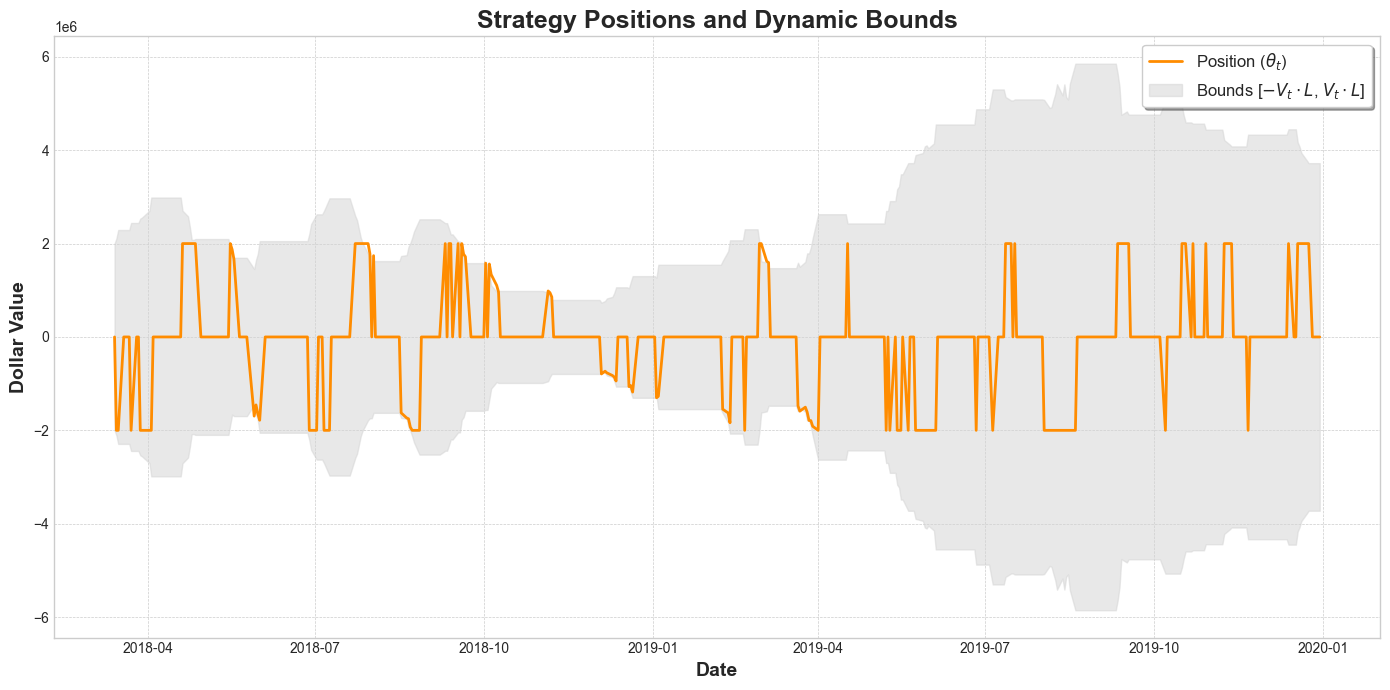

In [47]:
# PLOT THE POSITION OVER TIME AND THE DYNAMIC UPPER AND LOWER BOUNDS
# Add the positions list to sptl_test_data for plotting
sptl_test_data['Position'] = positions

# Calculate and add upper and lower bounds based on V0_evolution
sptl_test_data['Upper_Bound'] = [v0 * L for v0 in Vt_evolution]
sptl_test_data['Lower_Bound'] = [-v0 * L for v0 in Vt_evolution]

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting
plt.figure(figsize=(14, 7))

# Plot positions over time
plt.plot(sptl_test_data.index, sptl_test_data['Position'], label='Position ($\\theta_t$)', color='darkorange', linewidth=2)

# Plot dynamic upper and lower bounds with a fill
plt.fill_between(sptl_test_data.index, sptl_test_data['Lower_Bound'], sptl_test_data['Upper_Bound'], color='lightgray', alpha=0.5, label='Bounds [$-V_t \\cdot L$, $V_t \\cdot L$]')

# Set titles and labels with adjusted font sizes and weights
plt.title('Strategy Positions and Dynamic Bounds', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Dollar Value', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

Total Turnover: $170649480.48
Total Unit Turnover: 4735128.00


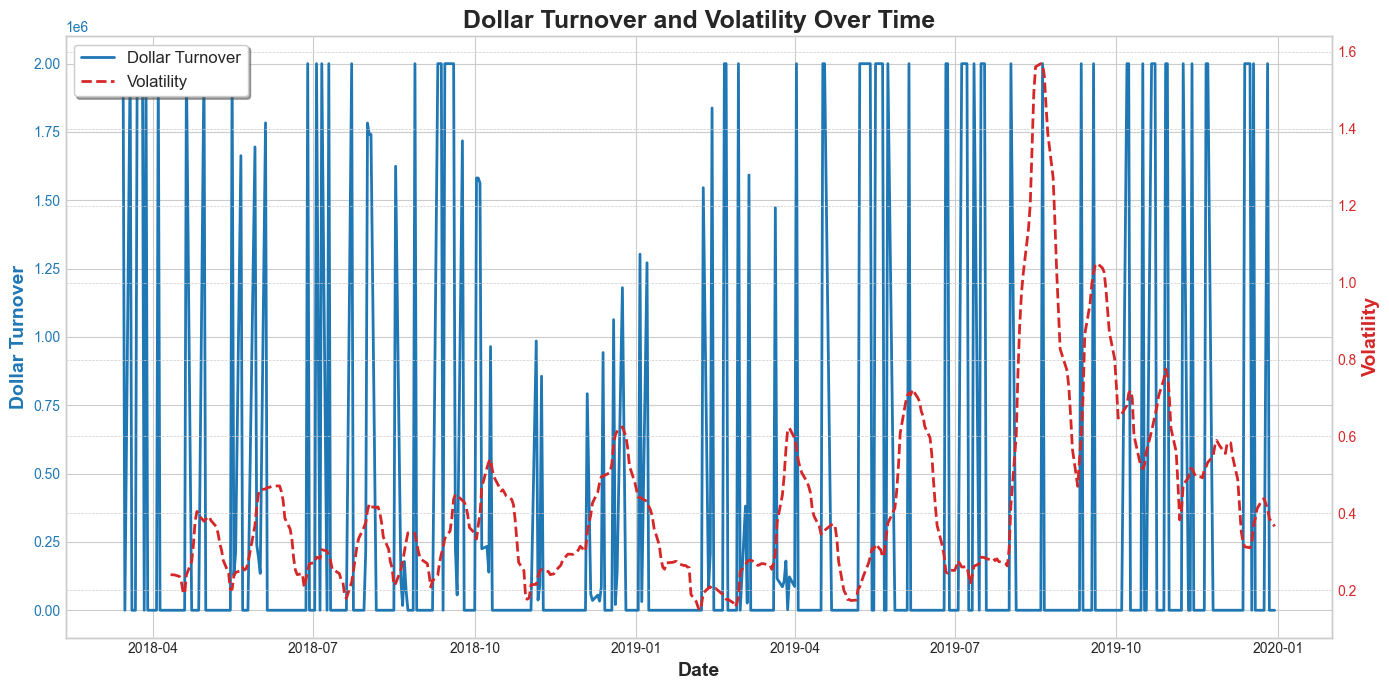

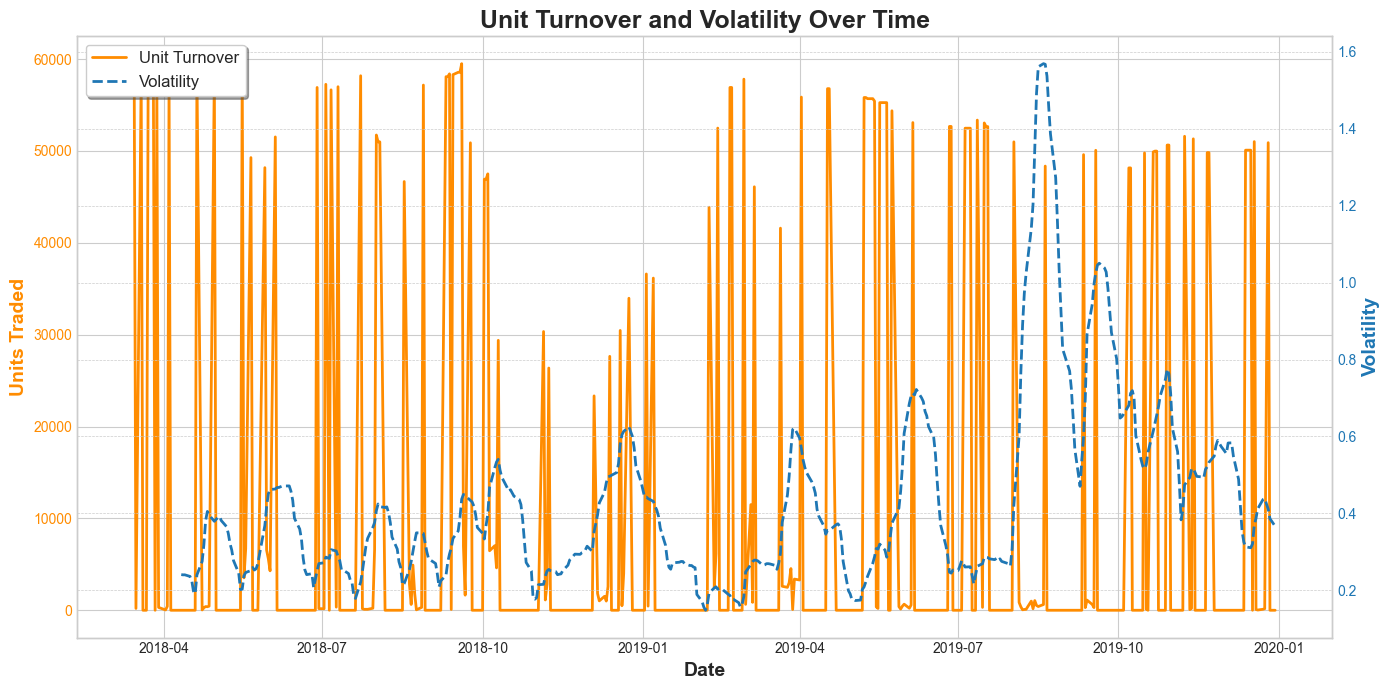

In [48]:
# Calculate the turnover in dollar value traded
sptl_test_data['Dollar_Turnover'] = sptl_test_data['Position'].diff().abs()

# Calculate the total turnover in dollar value traded
total_dollar_turnover = sptl_test_data['Dollar_Turnover'].sum()

# Calculate the turnover in units traded
sptl_test_data['Unit_Turnover'] = ((sptl_test_data['Position'].shift(1) / sptl_test_data['Close'].shift(1)) - (sptl_test_data['Position'] / sptl_test_data['Close'])).abs() 

# Calculate the total turnover in units traded
total_unit_turnover = sptl_test_data['Unit_Turnover'].sum()

print(f'Total Turnover: ${total_dollar_turnover:.2f}')
print(f'Total Unit Turnover: {total_unit_turnover:.2f}')

# Calculate the volatility of the close prices for SPTL
sptl_test_data['Volatility'] = sptl_test_data['Close'].rolling(window=20).std()


# Apply the Seaborn style for consistency and a cleaner look
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting
plt.figure(figsize=(14, 7))

# Primary y-axis for Dollar Turnover
color = 'tab:blue'
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Dollar Turnover', fontsize=14, fontweight='bold', color=color)
line1, = plt.plot(sptl_test_data.index, sptl_test_data['Dollar_Turnover'], label='Dollar Turnover', color=color, linewidth=2)
plt.tick_params(axis='y', labelcolor=color)

# Secondary y-axis for Volatility
ax2 = plt.gca().twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Volatility', fontsize=14, fontweight='bold', color=color)
line2, = ax2.plot(sptl_test_data.index, sptl_test_data['Volatility'], label='Volatility', color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Additional plot adjustments
plt.title('Dollar Turnover and Volatility Over Time', fontsize=18, fontweight='bold')

# Creating a legend that includes both lines
plt.legend([line1, line2], ['Dollar Turnover', 'Volatility'], loc='upper left', fontsize=12, frameon=True, shadow=True)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust the layout to make room for the dual y-axis

# Show plot
plt.show()


# Apply the Seaborn style for consistency
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting
plt.figure(figsize=(14, 7))

# Primary y-axis for Unit Turnover
color = 'darkorange'
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Units Traded', fontsize=14, fontweight='bold', color=color)
line1, = plt.plot(sptl_test_data.index, sptl_test_data['Unit_Turnover'], label='Unit Turnover', color=color, linewidth=2)
plt.tick_params(axis='y', labelcolor=color)

# Secondary y-axis for Volatility
ax2 = plt.gca().twinx()
color = 'tab:blue'
ax2.set_ylabel('Volatility', fontsize=14, fontweight='bold', color=color)
line2, = ax2.plot(sptl_test_data.index, sptl_test_data['Volatility'], label='Volatility', color=color, linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Additional plot adjustments
plt.title('Unit Turnover and Volatility Over Time', fontsize=18, fontweight='bold')

# Creatin a legend that includes both lines
plt.legend([line1, line2], ['Unit Turnover', 'Volatility'], loc='upper left', fontsize=12, frameon=True, shadow=True)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust the layout to make room for the dual y-axis

# Show plot
plt.show()

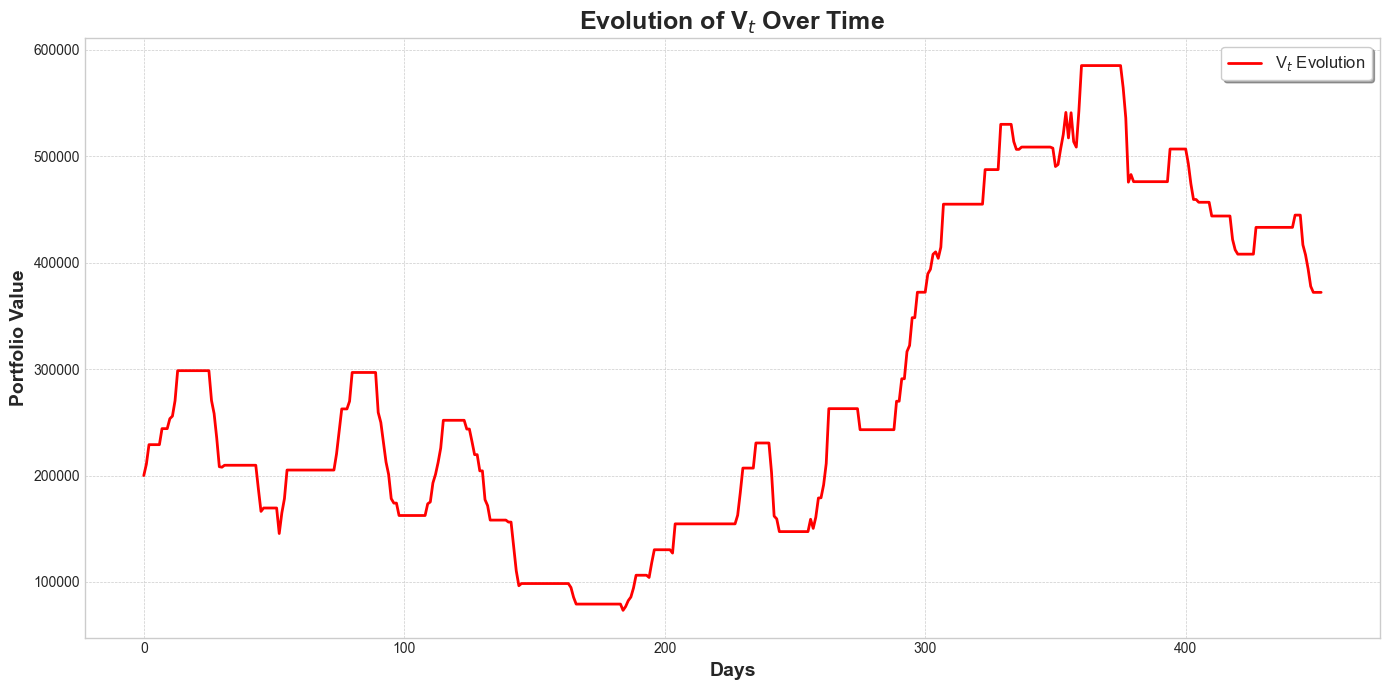

Vt_evolution: [200000.0, 210771.8213196168, 229049.23794198662, 229049.23794198662, 229049.23794198662, 229049.23794198662, 229049.23794198662, 244114.66349749744, 244114.66349749744, 244114.66349749744, 253429.61622571258, 255877.89243318324, 270350.7525042172, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 298586.70800161647, 270546.9055809184, 258227.2669225734, 235362.10219932522, 208332.80879526486, 207877.85835835495, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 209693.31116794742, 187315.1638686059, 166318.874902575, 169513.98356672653, 169513.98356672653, 169513.98356672653, 169513.98356672653, 16

In [49]:
# Plotting dVt over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(Vt_evolution, label='V$_t$ Evolution', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Evolution of V$_t$ Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

print(f'Vt_evolution: {Vt_evolution}')



Date
2018-03-14       0.000000
2018-03-15      -0.005675
2018-03-16       0.005675
2018-03-19    1134.920635
2018-03-20    1142.857143
                 ...     
2019-12-23      -0.012302
2019-12-24      -0.012302
2019-12-26    1230.158730
2019-12-27    1230.158730
2019-12-30    1230.158730
Name: dVtt, Length: 453, dtype: float64


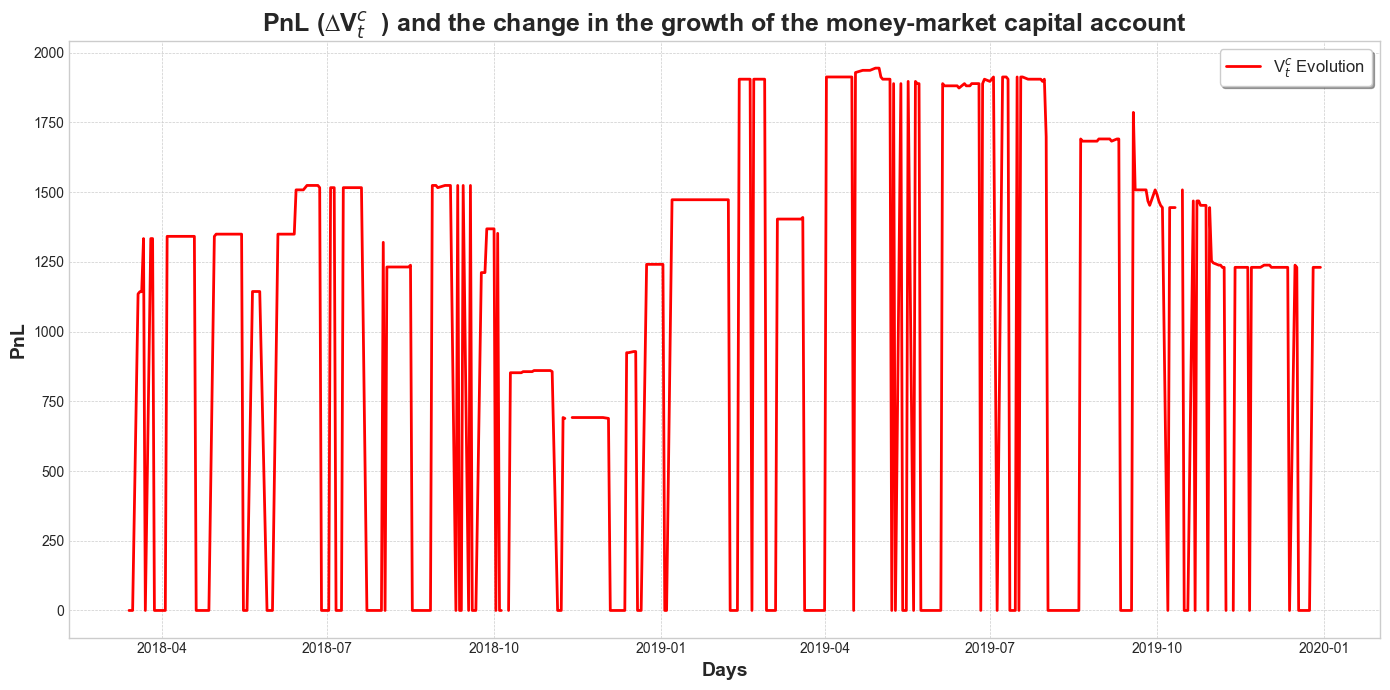

In [50]:
# calculating dVt(cap) over time
sptl_test_data['Mt'] = round((sptl_test_data['Position'].abs()) / L, 0)

sptl_test_data['Extra_Margin'] = sptl_test_data['Vt'] - sptl_test_data['Mt']
#print(sptl_test_data['Extra_Margin'])

sptl_test_data['dVtt'] = sptl_test_data['Extra_Margin'] * effr_data_df['EFFR_Adjusted']
print(sptl_test_data['dVtt'])

# Plotting dVt over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(sptl_test_data['dVtt'], label='V$_t^c$ Evolution', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('PnL (∆V$_t^c$  ) and the change in the growth of the money-market capital account', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()


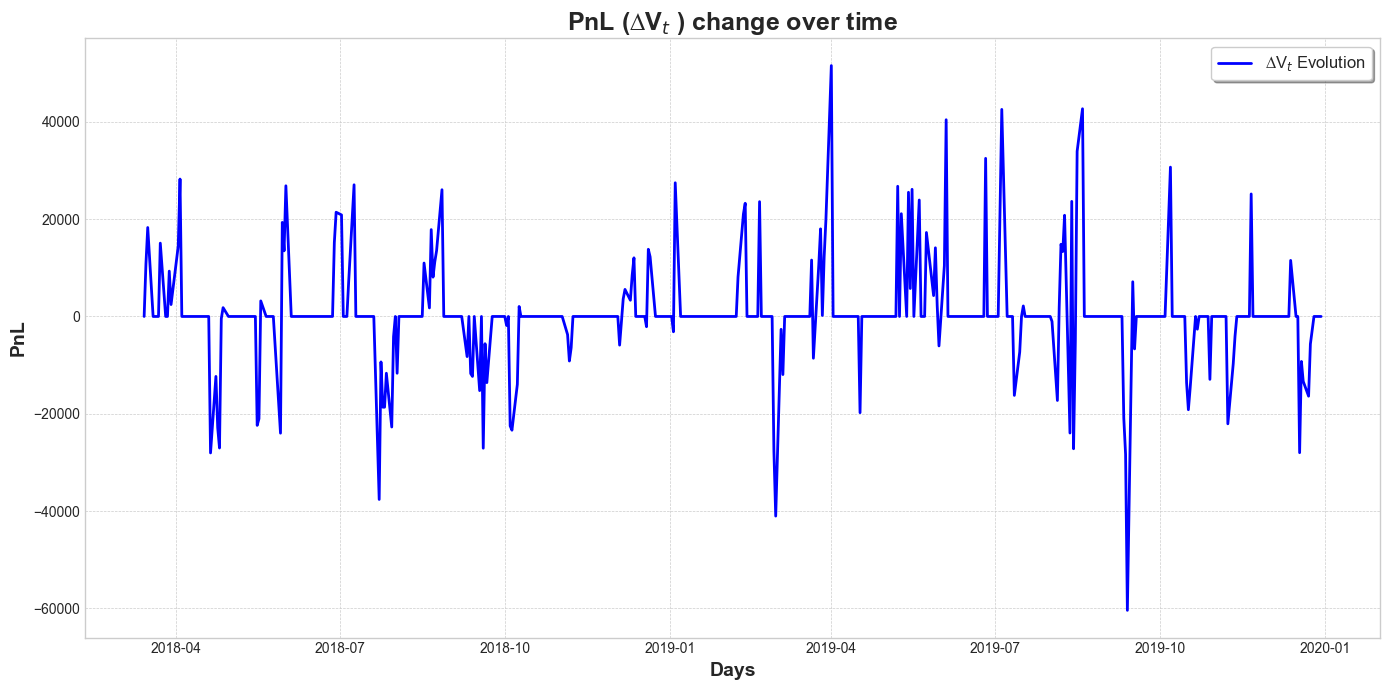

In [51]:
# Plotting dVt over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(sptl_test_data['dVt'], label='∆V$_t$ Evolution', color='blue', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('PnL (∆V$_t$ ) change over time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

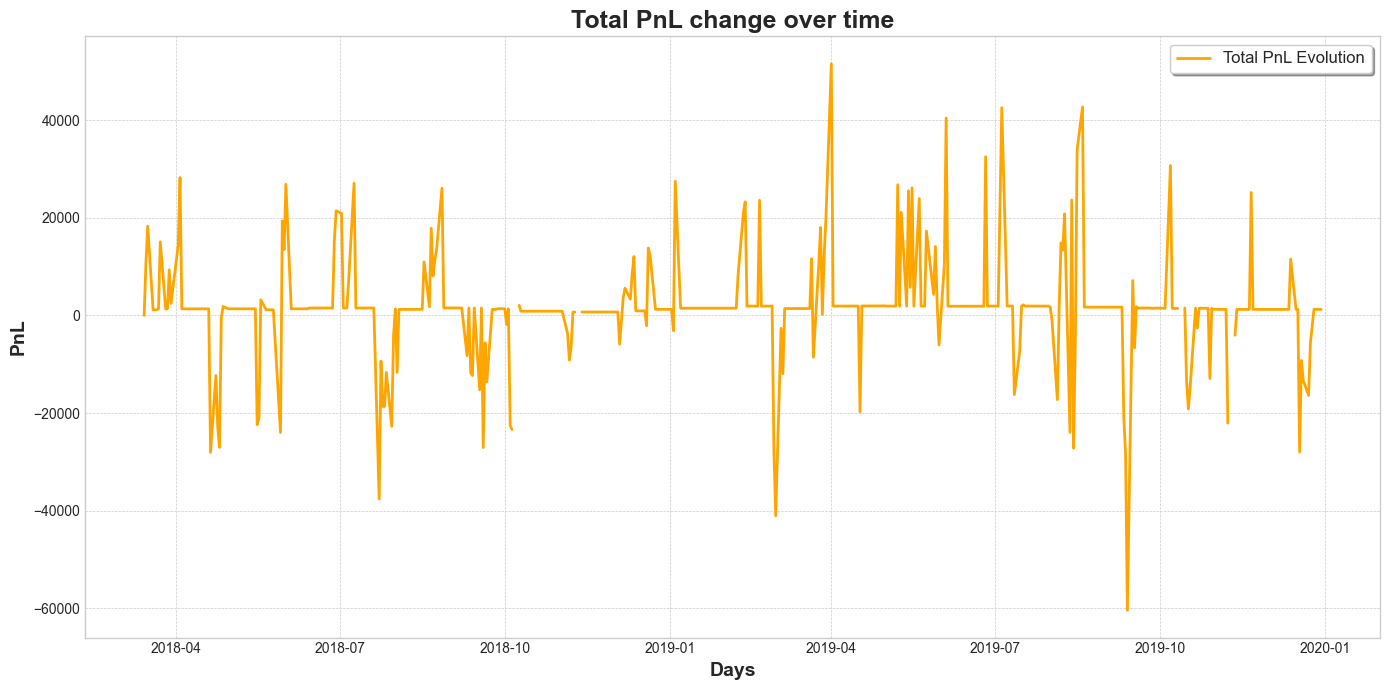

In [52]:
# Total PnL
sptl_test_data['Total_PnL'] = round(sptl_test_data['dVt'] + sptl_test_data['dVtt'],2)
#print(sptl_test_data['Total_PnL'])
#print(sptl_test_data['dVt'])

# Plot the total PnL over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(sptl_test_data['Total_PnL'], label='Total PnL Evolution', color='orange', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Total PnL change over time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

In [53]:
# TEST DATA METRICS
# Annualization factor
annualization_factor = np.sqrt(252)

# Sharpe Ratio (Annualized)
test_sharpe_ratio_annualized = (sptl_test_data['dVt'].mean() * annualization_factor) / (sptl_test_data['dVt'].std() * annualization_factor)
print(f'Sharpe Ratio (Annualized): {test_sharpe_ratio_annualized:.4f}')
# Sortino Ratio (Annualized)
downside_returns = sptl_test_data['dVt'][sptl_test_data['dVt'] < 0]
downside_std = downside_returns.std()
test_sortino_ratio_annualized = (sptl_test_data['dVt'].mean() * annualization_factor) / downside_std
print(f'Sortino Ratio (Annualized): {test_sortino_ratio_annualized:.4f}')
# Maximum Drawdown (No annualization needed)
cumulative_pnl = sptl_test_data['dVt'].cumsum()
cumulative_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - cumulative_max
max_drawdown = drawdown.min()
print(f'Maximum Drawdown: {max_drawdown:.2f}')
# Calmar Ratio (Annualized)
calmar_ratio_annualized = (sptl_test_data['dVt'].mean() * annualization_factor) / abs(max_drawdown)
print(f'Calmar Ratio (Annualized): {calmar_ratio_annualized:.4f}')

Sharpe Ratio (Annualized): 0.0361
Sortino Ratio (Annualized): 0.5533
Maximum Drawdown: -225244.15
Calmar Ratio (Annualized): 0.0268


In [58]:
## TRAIN DATA CALCULATION
# Initial capital
V0 = 200000.00

# Leverage
L = 10

# Maximum dollar value of SPTL that can be held, given the leverage
max_dollar_value = V0 * L
# Use the best parameters from the grid search output
best_ma_period = best_parameters['MA_Period']
best_z_threshold = best_parameters['Z_Score_Threshold']
# Position storage
positions = [0]
dVt = []
max_value = [0]

# Calculate moving average and standard deviation for the entire dataset
sptl_data['Moving_Average'] = sptl_data['Close'].rolling(window=int(best_ma_period)).mean()
sptl_data['MA_Std'] = sptl_data['Close'].rolling(window=int(best_ma_period)).std()

# Calculate Z-score for the entire dataset
sptl_data['Z_Score'] = (sptl_data['Close'] - sptl_data['Moving_Average']) / sptl_data['MA_Std']

# Generate signals based on the best Z-score threshold
sptl_data['Signal'] = 0
sptl_data.loc[sptl_data['Z_Score'] < -best_z_threshold, 'Signal'] = 1  # Buy signal
sptl_data.loc[sptl_data['Z_Score'] > best_z_threshold, 'Signal'] = -1  # Sell signal

# Reindex the EFFR data to align with sptl_data
sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


# Separate the training and test data
sptl_train_data = sptl_data.iloc[:train_rows].copy()

# Initialize a list to store the evolution of V0 over time
Vt_evolution = [V0]

# Calculate the daily returns for SPTL
sptl_train_data['Pct_Change'] = sptl_train_data['Close'].pct_change()
pnl = 0

# Simulate the trading strategy on the test data
for index, row in sptl_train_data.iterrows():
    # Calculate the position based on the signal
    # Handle the first iteration where there is no previous signal
    if index == sptl_train_data.index[0]:
        position = 0  # No position on the first day
    else:
        previous_signal = sptl_train_data.loc[sptl_train_data.index < index, 'Signal'].iloc[-1]
        max_value.append(max_dollar_value / L)
        position = previous_signal * (round((max_dollar_value / row['Close']), 0) * row['Close'])
        positions.append(position)  # Store the position for the row
    
    
    # Calculate PnL for the row
    if not np.isnan(row['MA_Std']) and not np.isnan(row['Pct_Change']):  # Avoid calculations before sufficient data for MA/STD
        pnl = (row['Pct_Change'] - row['EFFR_Adjusted']) * position
        V0 += pnl  # Update V0 with the PnL
        Vt_evolution.append(V0)  # Append the new V0 to the evolution list
    # Update the maximum dollar value based on the new V0
    max_dollar_value = min(V0 * L, 200000 * L)

    dVt.append(pnl) # Store the PnL for the row
sptl_train_data['Position'] = positions  # Store the positions in the DataFrame
sptl_train_data['Vt'] = max_value
sptl_train_data['dVt'] = dVt
# Print the evolution of V0 over time
for i, value in enumerate(Vt_evolution):
    print(f"Day {i}: V0 = {value:.2f}")

print(positions)


Day 0: V0 = 200000.00
Day 1: V0 = 200000.00
Day 2: V0 = 200000.00
Day 3: V0 = 183526.22
Day 4: V0 = 199530.63
Day 5: V0 = 199530.63
Day 6: V0 = 199530.63
Day 7: V0 = 199530.63
Day 8: V0 = 199530.63
Day 9: V0 = 199530.63
Day 10: V0 = 199530.63
Day 11: V0 = 199530.63
Day 12: V0 = 199530.63
Day 13: V0 = 199530.63
Day 14: V0 = 199530.63
Day 15: V0 = 199530.63
Day 16: V0 = 199530.63
Day 17: V0 = 199530.63
Day 18: V0 = 199530.63
Day 19: V0 = 199530.63
Day 20: V0 = 199530.63
Day 21: V0 = 199377.64
Day 22: V0 = 199377.64
Day 23: V0 = 226169.68
Day 24: V0 = 226169.68
Day 25: V0 = 226169.68
Day 26: V0 = 226169.68
Day 27: V0 = 226169.68
Day 28: V0 = 226169.68
Day 29: V0 = 226169.68
Day 30: V0 = 226169.68
Day 31: V0 = 226175.55
Day 32: V0 = 226175.55
Day 33: V0 = 226175.55
Day 34: V0 = 226175.55
Day 35: V0 = 226175.55
Day 36: V0 = 226175.55
Day 37: V0 = 226175.55
Day 38: V0 = 226175.55
Day 39: V0 = 226175.55
Day 40: V0 = 219625.09
Day 41: V0 = 226485.58
Day 42: V0 = 226485.58
Day 43: V0 = 226485.5

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_20671/3851268169.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


In [59]:
# TRAIN DATA METRICS
annualization_factor = np.sqrt(252)

# Sharpe Ratio (Annualized)
test_sharpe_ratio_annualized = (sptl_train_data['dVt'].mean() * annualization_factor) / (sptl_train_data['dVt'].std() * annualization_factor)
print(f'Sharpe Ratio (Annualized): {test_sharpe_ratio_annualized:.4f}')
# Sortino Ratio (Annualized)
downside_returns = sptl_train_data['dVt'][sptl_train_data['dVt'] < 0]
downside_std = downside_returns.std()
test_sortino_ratio_annualized = (sptl_train_data['dVt'].mean() * annualization_factor) / downside_std
print(f'Sortino Ratio (Annualized): {test_sortino_ratio_annualized:.4f}')
# Maximum Drawdown (No annualization needed)
cumulative_pnl = sptl_train_data['dVt'].cumsum()
cumulative_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - cumulative_max
max_drawdown = drawdown.min()
print(f'Maximum Drawdown: {max_drawdown:.2f}')
# Calmar Ratio (Annualized)
calmar_ratio_annualized = (sptl_train_data['dVt'].mean() * annualization_factor) / abs(max_drawdown)
print(f'Calmar Ratio (Annualized): {calmar_ratio_annualized:.4f}')

Sharpe Ratio (Annualized): 0.0477
Sortino Ratio (Annualized): 0.6171
Maximum Drawdown: -242115.62
Calmar Ratio (Annualized): 0.0278


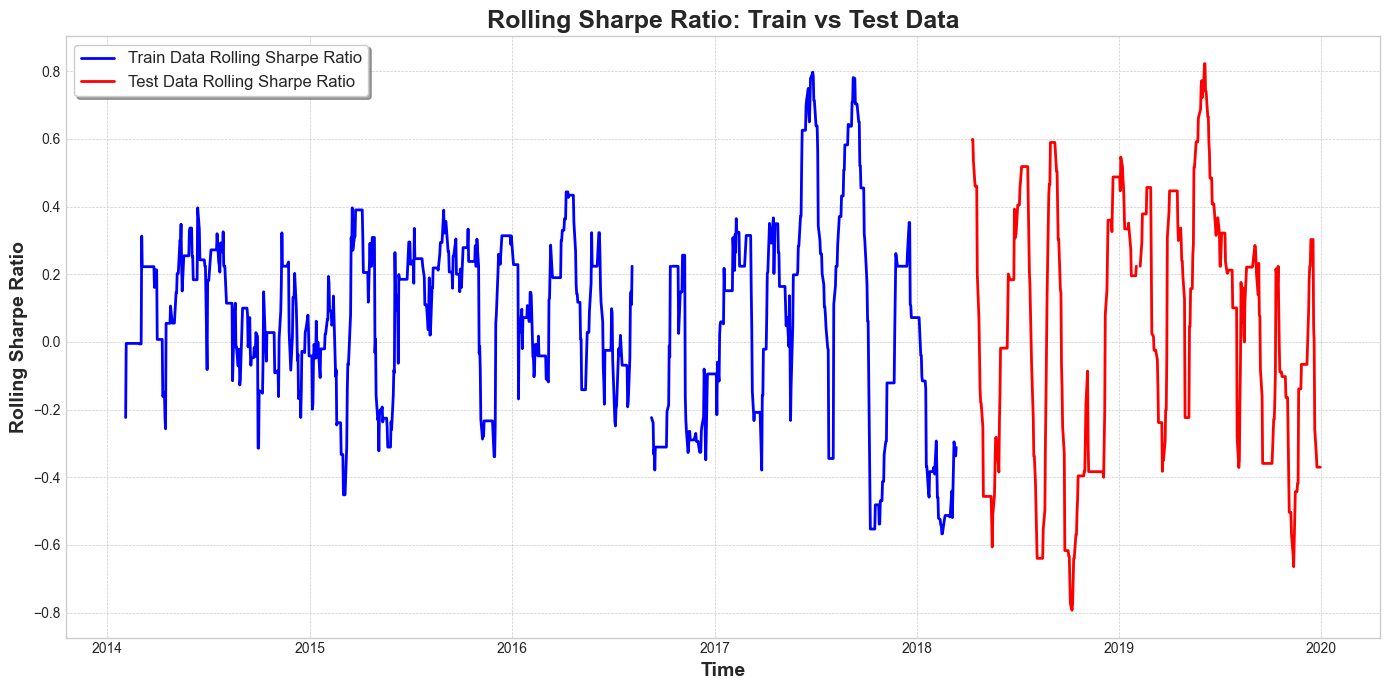

In [60]:

# Calculate the rolling Sharpe ratio for the train data
rolling_sharpe_ratio_train = sptl_train_data['dVt'].rolling(window=20).mean() / sptl_train_data['dVt'].rolling(window=20).std()
# calculate the rolling Sharpe ratio for the test data  
rolling_sharpe_ratio_test = sptl_test_data['dVt'].rolling(window=20).mean() / sptl_test_data['dVt'].rolling(window=20).std()

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the Rolling Sharpe Ratio for both Train and Test Data
plt.figure(figsize=(14, 7))
plt.plot(rolling_sharpe_ratio_train, label='Train Data Rolling Sharpe Ratio', color='blue', linewidth=2)
plt.plot(rolling_sharpe_ratio_test, label='Test Data Rolling Sharpe Ratio', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Rolling Sharpe Ratio: Train vs Test Data', fontsize=18, fontweight='bold')
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

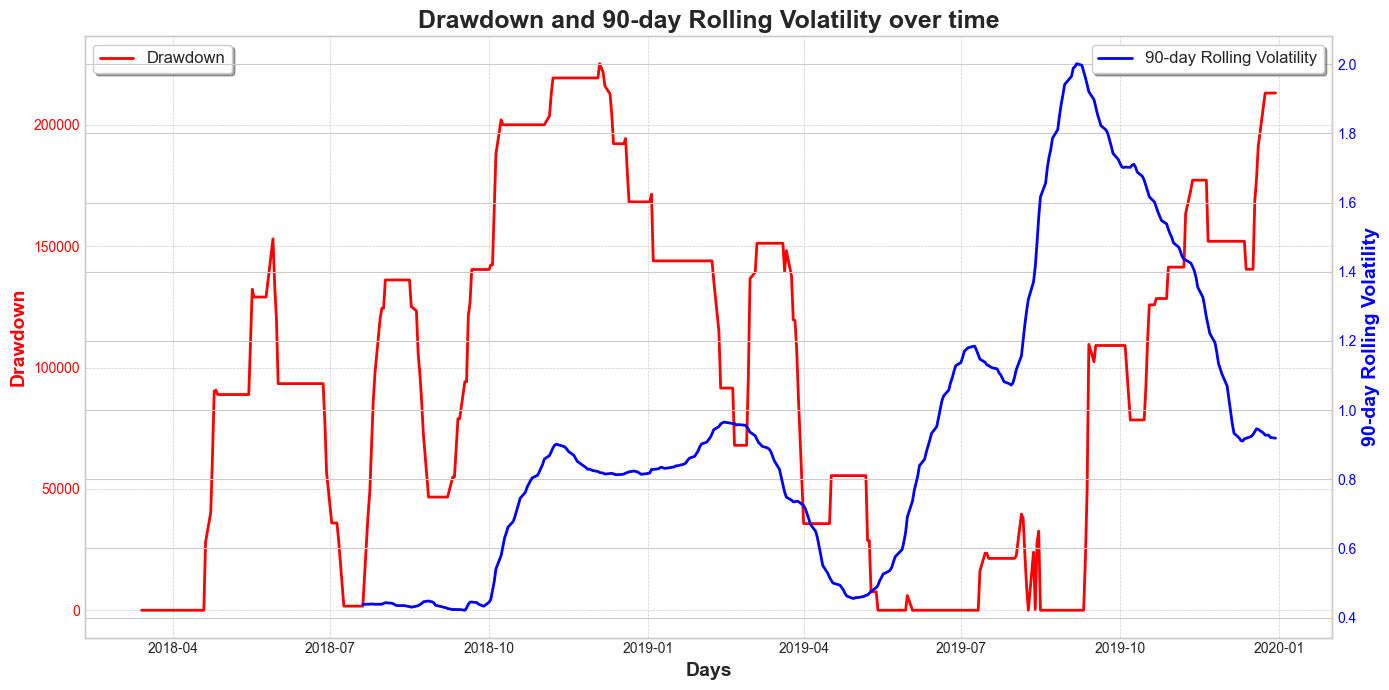

In [61]:
# Calculate the drawdown over time and the historic rolling 90-day volatility of the underlying asset for the test set
# Calculate the cumulative PnL
sptl_test_data['Cumulative_PnL'] = sptl_test_data['dVt'].cumsum()

# Calculate the rolling maximum of the cumulative PnL to represent the peak
sptl_test_data['Rolling_Max_PnL'] = sptl_test_data['Cumulative_PnL'].cummax()

# Calculate the Drawdown
sptl_test_data['Drawdown'] = sptl_test_data['Rolling_Max_PnL'] - sptl_test_data['Cumulative_PnL']



# Calculate the historic rolling 90-day volatility of the closing prices
sptl_test_data['Volatility'] = sptl_test_data['Close'].rolling(window=90).std()

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and the first axis for the Drawdown
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Drawdown on the first axis
ax1.plot(sptl_test_data.index, sptl_test_data['Drawdown'], label='Drawdown', color='red', linewidth=2)
ax1.set_xlabel('Days', fontsize=14, fontweight='bold')
ax1.set_ylabel('Drawdown', color='red', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)

# Create a second axis for the volatility shared x-axis with the first axis
ax2 = ax1.twinx()
ax2.plot(sptl_test_data.index, sptl_test_data['Volatility'], label='90-day Rolling Volatility', color='blue', linewidth=2)
ax2.set_ylabel('90-day Rolling Volatility', color='blue', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

# Set title and grid
plt.title('Drawdown and 90-day Rolling Volatility over time', fontsize=18, fontweight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
fig.tight_layout()

# Display the plot
plt.show()